In [121]:
Student_1 = '' #@param {type:"string"}  Name of student 1
Student_2 = '' #@param {type:"string"}  Name of student 2
Student_3 = '' #@param {type:"string"}  Name of student 3
Student_4 = '' #@param {type:"string"}  Name of student 4

# Overview

This is the skeleton code file for the EEC4400 assignment. Replace the `XX`. in the name of this Jupyter notebook with your group number (this is important for correct marks to be awarded to your group). Fill in the blank cells below with the necessary code (you should work on this Jupyter notebook section by section). At the end, the entire Jupyter notebook should generate all the required results and execute without error.

The text above the blank cells provides information on the functionality that needs to be implemented. You need to write Python code at places indicated by `[WriteCode]`

## Install and Import Libraries

In [122]:
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

import os
import time
import numpy as np
import random
from collections import deque

import gymnasium as gym

# Background

## Environment Exploration: Cart-Pole

The **Cart-Pole environment** is a classic reinforcement learning problem where a pole is attached by an un-actuated joint to a cart. The cart moves along a frictionless track, and the goal is to balance the pole upright by applying forces to move the cart left or right.

<img src="https://gymnasium.farama.org/_images/cart_pole.gif" width="400">

Below is a breakdown of the base Cart-Pole environment:


#### - **Observation Space (*s*)**
The observation is represented as a `ndarray` of shape `(4,)`, corresponding to:
- **Cart Position**: Horizontal location of the cart.
- **Cart Velocity**: Speed of the cart along the track.
- **Pole Angle**: Angular position of the pole relative to vertical.
- **Pole Angular Velocity**: Speed at which the pole angle changes.

The observations are initialized with uniformly random values in the range `(-0.05, 0.05)`.


#### - **Action Space (*a*)**
The action is a discrete value (`0` or `1`) indicating the direction of the force applied to the cart:
- `0`: Push the cart to the left.
- `1`: Push the cart to the right.



#### - **Reward Function (*r*)**
The agent receives a reward of `+1` for each time step it successfully keeps the pole upright. The maximum achievable reward in a single episode is `500`.

#### - **Episode Termination (*isDone*)**
An episode ends if any of the following conditions occur:
1. **Pole Angle** exceeds `±12°`.
2. **Cart Position** exceeds `±2.4` (the cart reaches the edge of the track).
3. **Truncation**: The episode reaches the maximum length of `500 steps`.

## Getting Familiar with Basic Gymnasium Usage

Let's observe how to interact with a Gymnasium environment.

The classic “agent-environment loop” pictured below is a simplified representation of reinforcement learning that Gymnasium implements.

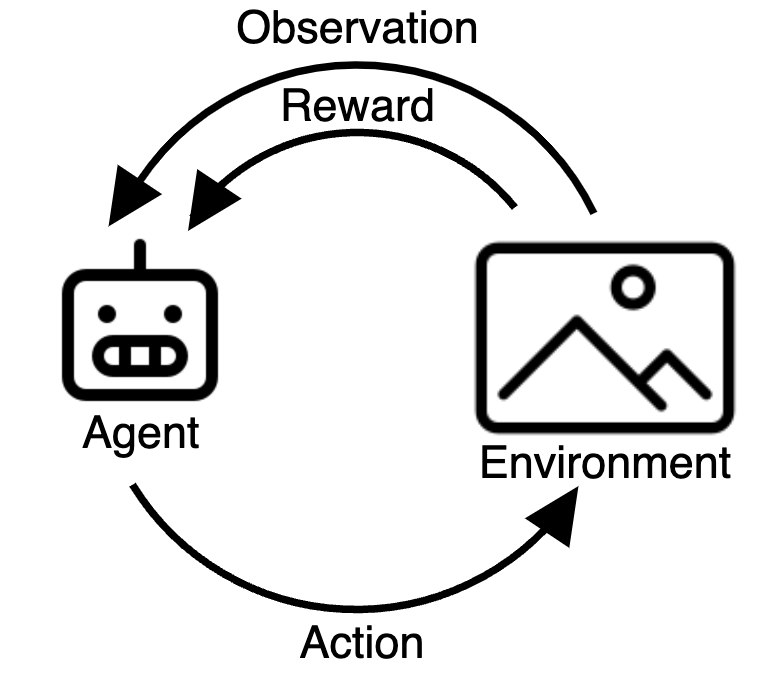

The following section represents a simple episode of this loop, we will:

1. Import the base Cart-Pole environment from the gymnasium library and explore its functionality.

2. Apply modifications to make the environment more challenging by adjusting the pole's dynamics and introducing stochastic forces.

3. Sample random actions to control the cart-pole.

These steps will help us understand how the environment behaves under different conditions and prepare us for implementing reinforcement learning agents in later sections.



In [123]:
import warnings
warnings.filterwarnings('ignore')

# Import and Explore the Environment
print("\n--- Exploring the Base Environment ---")
env = gym.make("CartPole-v1")
observation, info = env.reset()

# Print information about the environment
print(f"Initial Observation: {observation}")
print(f"Action Space: {env.action_space}")  # Discrete actions: 0 (left), 1 (right)
print(f"Observation Space: {env.observation_space}")  # State variables: cart position, etc.


--- Exploring the Base Environment ---
Initial Observation: [0.00394664 0.00563844 0.03847814 0.03783673]
Action Space: Discrete(2)
Observation Space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)


# Define Helper Functions

## Plotting Functions

In [124]:
# Some plotting functions
import matplotlib.pyplot as plt

def plot_eval_rwd_mean(eval_mean_list):
    """Plot evaluation reward mean."""
    if len(eval_mean_list) == 0:
        print("eval_mean_list is empty, nothing to plot.")
        return
    
    episodes = range(1, len(eval_mean_list) + 1)

    plt.figure()
    plt.plot(episodes, eval_mean_list)
    plt.xlabel("Episode")
    plt.ylabel("Evaluation Reward (mean)")
    plt.title("Evaluation Reward Mean per Episode")
    plt.grid(True)
    plt.show()


def plot_eval_rwd_var(eval_var_list):
    """Plot evaluation reward variance."""
    if len(eval_var_list) == 0:
        print("eval_var_list is empty, nothing to plot.")
        return

    episodes = range(1, len(eval_var_list) + 1)

    plt.figure()
    plt.plot(episodes, eval_var_list)
    plt.xlabel("Episode")
    plt.ylabel("Evaluation Reward (variance)")
    plt.title("Evaluation Reward Variance per Episode")
    plt.grid(True)
    plt.show()



def plot_smoothed_training_rwd(train_rwd_list, window_size=20):
    """Plot smoothed training rewards using a moving average."""
    n = len(train_rwd_list)
    if n == 0:
        print("train_rwd_list is empty, nothing to plot.")
        return
    
    # 如果 episode 数比窗口小，就把窗口缩短
    window_size = min(window_size, n)

    # 简单的滑动平均
    smoothed = []
    for i in range(n - window_size + 1):
        window = train_rwd_list[i:i + window_size]
        smoothed.append(sum(window) / window_size)

    # 对应的 episode 编号（从 window_size 开始）
    episodes = range(window_size, n + 1)

    plt.figure()
    plt.plot(episodes, smoothed)
    plt.xlabel("Episode")
    plt.ylabel(f"Training Reward (moving average, window={window_size})")
    plt.title("Smoothed Training Reward")
    plt.grid(True)
    plt.show()

## Evaluation Function

Evaluate the learnt policy by running 5 evaluation episodes and computing the average and variance of rewards collected.

In [125]:
def evaluation(model, max_timesteps=500):
    eval_env = gym.make("CartPole-v1")
    state_size = eval_env.observation_space.shape[0] # Number of observations (CartPole)
    action_size = eval_env.action_space.n            # Number of possible actions
    eval_reward = []

    for i in range (5):
        round_reward = 0
        state, _ = eval_env.reset()
        state = np.reshape(state, [1, state_size])

        for i in range(max_timesteps):
            action = np.argmax(model.predict(state, verbose=0)[0])
            next_state, reward, terminated, truncated, _ = eval_env.step(action)
            next_state = np.reshape(next_state, [1, state_size])

            round_reward += reward
            state = next_state

            if terminated or truncated:
                eval_reward.append(round_reward)
                break

    eval_env.close()

    eval_reward_mean = np.sum(eval_reward)/len(eval_reward)
    eval_reward_var = np.var(eval_reward)

    return eval_reward_mean, eval_reward_var

# Setting up Tensorboard


In [126]:
def get_run_logdir(k):
    root_logdir = os.path.join(os.curdir, "eec4400_logs", k)
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

# Initialize Parameters

In [127]:
# Use the following set of NN hyperparameters for ALL FOUR baseline policies
lr =  0.001        #@param {type:"number"}               # learning rate
epoch =  1     #@param {type:"number"}               # epochs
episode = 250  #@param {type:"number"}               # episodes

epsilon = 1           #@param {type:"number"}     # Starting exploration rate
epsilon_min = 0.01    #@param {type:"number"}     # Exploration rate min
epsilon_decay = 0.995     #@param {type:"number"}     # Exploration rate decay

gamma = 0.99          #@param {type:"number"}     # Agent discount factor

# Use the following set of NN hyperparameters for Naive DQN, DQN and DDQN policies
ba =  32       #@param {type:"number"}               # batch_size

# Use the following set of RL hyperparameters for DQN and DDQN policies
target_update_freq = 50 # @param {type:"number"}    # Target network update frequency

# Q-Network - Baseline

## Define and Compile the Neural Network

A single network $Q_\theta$ (parameterized by $\theta$) is used to approximate $Q(s,a)$.

The target used by Naive DQN is then:

$Y^{NaiveQ}_t = R_{t+1} + \gamma Q_{\theta}(S_{t+1}, a)$

The training of Q-Network does NOT rely on a Replay Buffer.


In [133]:
# ========== 第一板块：模型构建（添加目标网络） ==========
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
import gymnasium as gym

# 1. 复用全局超参数（不重新定义，确保基线一致性）
# 全局超参数：lr=0.001、epoch=1、episode=250、target_update_freq=50等

# 2. 构建环境
env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# 3. 构建在线网络（用于选择动作和更新参数）- 基线架构
model = Sequential()
model.add(Dense(24, activation='relu', input_shape=(state_size,)))  # 全局统一基线：24×24隐藏层
model.add(Dense(24, activation='relu'))
model.add(Dense(action_size, activation='linear'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')  # 复用全局lr=0.001

# 4. 构建目标网络（用于计算稳定目标Q值）- 与在线网络架构完全一致
target_model = Sequential()
target_model.add(Dense(24, activation='relu', input_shape=(state_size,)))
target_model.add(Dense(24, activation='relu'))
target_model.add(Dense(action_size, activation='linear'))
target_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')
target_model.set_weights(model.get_weights())  # 初始参数同步

## Set Up Env and Train the Policy

In [129]:
# ========== 第二板块：训练循环（修改后） ==========
# For logging
train_reward_lst = []
eval_reward_mean_lst = []
eval_reward_var_lst = []

total_training_time = 0

for ep in range(episode):  # 复用全局episode=250
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    start = time.time()

    for _ in range(500):
        # ε-贪婪策略选动作（复用全局epsilon相关参数）
        if np.random.rand() <= epsilon:
            action = np.random.choice(action_size)
        else:
            q_values = model.predict(state, verbose=0)
            action = np.argmax(q_values[0])

        # 执行动作，获取反馈
        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        done = terminated or truncated

        # 计算目标Q值（用目标网络+全局gamma=0.99）
        current_q = model.predict(state, verbose=0)
        if done:
            target_q = reward
        else:
            next_q = target_model.predict(next_state, verbose=0)  # 目标网络稳定预测
            target_q = reward + gamma * np.max(next_q)

        # 更新当前动作的Q值并训练
        current_q[0][action] = target_q
        model.fit(state, current_q, epochs=epoch, verbose=0)  # 复用全局epoch=1

        # 衰减探索率（复用全局epsilon_decay=0.995、epsilon_min=0.01）
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

        # 状态更新与奖励累计
        state = next_state
        total_reward += reward
        if done:
            break

    # 记录训练时间
    end = time.time()
    total_training_time += end - start

    # 调用全局evaluation函数（避免重复定义）
    eval_reward_mean, eval_reward_var = evaluation(model)

    # 打印日志
    print(f"Episode {ep + 1}/{episode} | Ep. Total Reward: {total_reward:.0f}"
          f" | Epsilon : {epsilon:.3f}"
          f" | Eval Rwd Mean: {eval_reward_mean:.2f}"
          f" | Eval Rwd Var: {eval_reward_var:.2f}")

    # 日志存储
    train_reward_lst.append(total_reward)
    eval_reward_mean_lst.append(eval_reward_mean)
    eval_reward_var_lst.append(eval_reward_var)

    # 按全局频率更新目标网络（target_update_freq=50）
    if (ep + 1) % target_update_freq == 0:
        target_model.set_weights(model.get_weights())

    # 早停逻辑
    if eval_reward_mean >= 500:
        print(f"Early stopping triggered at Episode {ep + 1}.")
        break

# 计算平均训练时间（兼容早停）
avg_train_time = total_training_time / (ep + 1)
print(f"Training time: {avg_train_time:.4f} seconds per episode")
env.close()

Episode 1/250 | Ep. Total Reward: 21 | Epsilon : 0.900 | Eval Rwd Mean: 10.00 | Eval Rwd Var: 0.00
Episode 2/250 | Ep. Total Reward: 17 | Epsilon : 0.827 | Eval Rwd Mean: 9.80 | Eval Rwd Var: 0.16
Episode 3/250 | Ep. Total Reward: 43 | Epsilon : 0.666 | Eval Rwd Mean: 9.20 | Eval Rwd Var: 0.56
Episode 4/250 | Ep. Total Reward: 9 | Epsilon : 0.637 | Eval Rwd Mean: 9.40 | Eval Rwd Var: 0.64
Episode 5/250 | Ep. Total Reward: 14 | Epsilon : 0.594 | Eval Rwd Mean: 9.40 | Eval Rwd Var: 1.04
Episode 6/250 | Ep. Total Reward: 20 | Epsilon : 0.537 | Eval Rwd Mean: 9.60 | Eval Rwd Var: 1.04
Episode 7/250 | Ep. Total Reward: 10 | Epsilon : 0.511 | Eval Rwd Mean: 9.40 | Eval Rwd Var: 1.04
Episode 8/250 | Ep. Total Reward: 11 | Epsilon : 0.483 | Eval Rwd Mean: 9.40 | Eval Rwd Var: 1.04
Episode 9/250 | Ep. Total Reward: 17 | Epsilon : 0.444 | Eval Rwd Mean: 9.60 | Eval Rwd Var: 1.04
Episode 10/250 | Ep. Total Reward: 17 | Epsilon : 0.408 | Eval Rwd Mean: 9.60 | Eval Rwd Var: 0.24
Episode 11/250 | Ep

## Plot Results

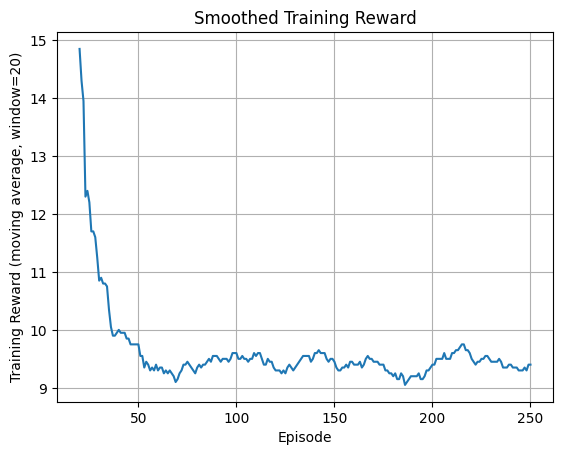

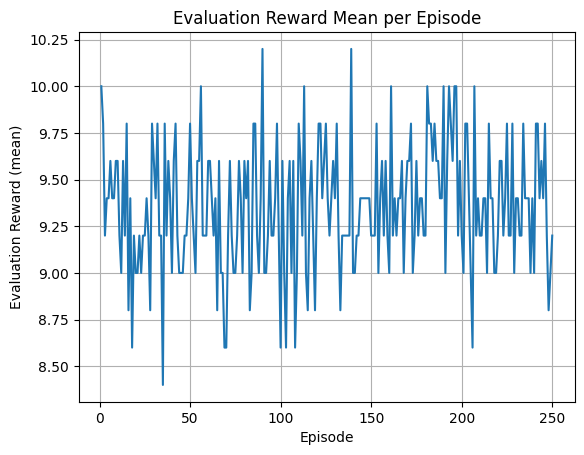

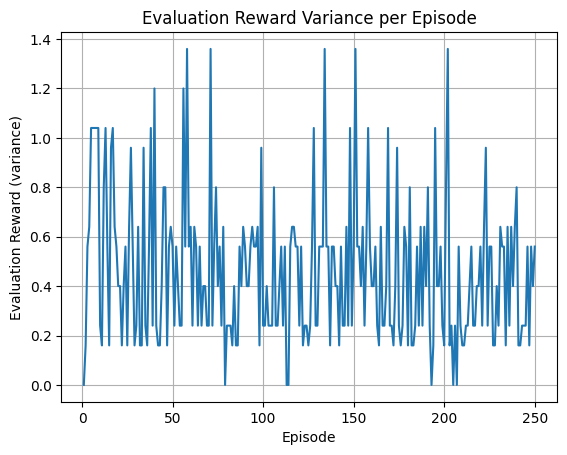

In [132]:

plot_smoothed_training_rwd(train_reward_lst, window_size=20)
plot_eval_rwd_mean(eval_reward_mean_lst)
plot_eval_rwd_var(eval_reward_var_lst)

# Q-Network - Alternative

In [146]:
# Q-Network - Alternative（Student1调优策略：纯基础Q-Network，无目标网络/经验回放）
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import numpy as np
import gymnasium as gym
import time

# ========================= 1. 新调优参数（纯基础Q-Network专属） =========================
lr_alt = 0.0001        # 更慢学习率，减少震荡
epoch_alt = 1           # 单步更新（基础Q-Net标准）
episodes_alt = 500      # 延长训练轮次
epsilon_alt = 1.0       # 初始全探索
epsilon_min_alt = 0.01  # 更高最小探索率，避免停滞
epsilon_decay_alt = 0.997  # 极慢衰减，延长探索期
gamma_alt = 0.99        # 保留长期奖励权重
hidden_units1_alt = 16  # 精简网络容量，避免过拟合
hidden_units2_alt = 16  # 精简第二隐藏层

# ========================= 2. 环境初始化 =========================
env_alt = gym.make("CartPole-v1")
state_size_alt = env_alt.observation_space.shape[0]
action_size_alt = env_alt.action_space.n

# ========================= 3. 模型定义（纯基础Q-Network：无目标网络） =========================
model_alt = Sequential()
model_alt.add(Dense(hidden_units1_alt, input_dim=state_size_alt, activation='relu'))
model_alt.add(Dense(hidden_units2_alt, activation='relu'))
model_alt.add(Dense(action_size_alt, activation='linear'))
model_alt.compile(optimizer=Adam(learning_rate=lr_alt), loss='mean_squared_error')
model_alt.summary()

# ========================= 4. 核心训练循环（纯基础Q-Learning：单网络+单步更新） =========================
train_rewards_alt = []
eval_means_alt = []
eval_vars_alt = []
total_training_time_alt = 0

for ep in range(episodes_alt):
    state, _ = env_alt.reset()
    state = np.reshape(state, [1, state_size_alt])
    episode_reward_alt = 0
    start_time = time.time()

    for step in range(500):
        # 1. ε-贪婪动作选择
        if np.random.rand() <= epsilon_alt:
            action = np.random.choice(action_size_alt)
        else:
            q_values_alt = model_alt.predict(state, verbose=0)
            action = np.argmax(q_values_alt[0])

        # 2. 执行动作获取反馈
        next_state, reward, terminated, truncated, _ = env_alt.step(action)
        next_state = np.reshape(next_state, [1, state_size_alt])
        done = terminated or truncated

        # 3. 基础Q-Learning更新（无目标网络，直接用当前网络预测）
        current_q_alt = model_alt.predict(state, verbose=0)
        if done:
            target_q_alt = reward
        else:
            next_q_alt = model_alt.predict(next_state, verbose=0)
            target_q_alt = reward + gamma_alt * np.max(next_q_alt)
        current_q_alt[0][action] = target_q_alt

        # 4. 单步训练
        model_alt.fit(state, current_q_alt, epochs=epoch_alt, verbose=0)

        # 5. 探索率衰减
        if epsilon_alt > epsilon_min_alt:
            epsilon_alt *= epsilon_decay_alt

        # 6. 状态更新与奖励累计
        state = next_state
        episode_reward_alt += reward
        if done:
            break

    # 后处理：时间记录+评估（调用全局evaluation函数）
    end_time = time.time()
    total_training_time_alt += (end_time - start_time)
    eval_mean_alt, eval_var_alt = evaluation(model_alt)

    # 打印日志
    print(f"Alternative Q-Net Episode {ep + 1}/{episodes_alt} | "
          f"Training Reward: {episode_reward_alt:.0f} | "
          f"Epsilon: {epsilon_alt:.3f} | "
          f"Eval Mean: {eval_mean_alt:.2f} | "
          f"Eval Var: {eval_var_alt:.2f}")

    # 日志存储
    train_rewards_alt.append(episode_reward_alt)
    eval_means_alt.append(eval_mean_alt)
    eval_vars_alt.append(eval_var_alt)

    # 早停逻辑
    if eval_mean_alt >= 500:
        print(f"\nEarly Stopping Triggered! Converged at Episode {ep + 1}")
        break

# 计算平均训练时间
avg_train_time_alt = total_training_time_alt / (ep + 1)
print(f"\nAverage Training Time per Episode (Alternative): {avg_train_time_alt:.4f} seconds")

# 环境清理
env_alt.close()

# ========================= 5. 结果可视化（复用全局绘图函数） =========================
print("\n===== Alternative Q-Network - Tuned Result Visualization =====")
plot_smoothed_training_rwd(train_rewards_alt, window_size=20)
plot_eval_rwd_mean(eval_means_alt)
plot_eval_rwd_var(eval_vars_alt)

Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_147 (Dense)               │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_148 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_149 (Dense)               │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 386 (1.51 KB)

 Trainable params: 386 (1.51 KB)

 Non-trainable params: 0 (0.00 B)

Alternative Q-Net Episode 1/500 | Training Reward: 13 | Epsilon: 0.962 | Eval Mean: 166.00 | Eval Var: 15281.60
Alternative Q-Net Episode 2/500 | Training Reward: 76 | Epsilon: 0.765 | Eval Mean: 100.20 | Eval Var: 1844.96
Alternative Q-Net Episode 3/500 | Training Reward: 19 | Epsilon: 0.723 | Eval Mean: 112.00 | Eval Var: 1491.20
Alternative Q-Net Episode 4/500 | Training Reward: 33 | Epsilon: 0.655 | Eval Mean: 171.40 | Eval Var: 4843.04
Alternative Q-Net Episode 5/500 | Training Reward: 21 | Epsilon: 0.615 | Eval Mean: 124.40 | Eval Var: 2425.04
Alternative Q-Net Episode 6/500 | Training Reward: 59 | Epsilon: 0.515 | Eval Mean: 238.80 | Eval Var: 6768.16
Alternative Q-Net Episode 7/500 | Training Reward: 41 | Epsilon: 0.455 | Eval Mean: 107.20 | Eval Var: 3895.36
Alternative Q-Net Episode 8/500 | Training Reward: 40 | Epsilon: 0.404 | Eval Mean: 142.20 | Eval Var: 10957.76
Alternative Q-Net Episode 9/500 | Training Reward: 81 | Epsilon: 0.316 | Eval Mean: 107.80 | Eval Var: 1544.56

KeyboardInterrupt: 

## Comparison

Compare performance of the Baseline and the Alternative Naive Q-Network policies

In [ ]:
## 基线与替代策略性能对比
import pandas as pd

# 整理对比数据
comparison_data = {
    "指标": [
        "最终评估均值", 
        "最终评估方差", 
        "平均每轮训练时间（秒）", 
        "收敛轮次（达到500分）"
    ],
    "基线策略": [
        eval_reward_mean_lst[-1],  # 最后一轮的评估均值
        eval_reward_var_lst[-1],   # 最后一轮的评估方差
        avg_train_time,
        len(train_reward_lst)      # 总训练轮次（早停则为早停轮次）
    ],
    "替代策略": [
        eval_reward_mean_lst_alt[-1],
        eval_reward_var_lst_alt[-1],
        avg_train_time_alt,
        len(train_reward_lst_alt)
    ]
}

# 转换为表格并打印
df = pd.DataFrame(comparison_data)
print("\n===== 基线策略与替代策略对比 =====")
print(df.round(3))  # 保留3位小数

# 绘制移动平均奖励对比图
plt.figure(figsize=(10, 5))
# 基线策略平滑奖励
smoothed_base = np.convolve(train_reward_lst, np.ones(20)/20, mode='valid')
episodes_base = np.arange(20, len(train_reward_lst) + 1)
# 替代策略平滑奖励
smoothed_alt = np.convolve(train_reward_lst_alt, np.ones(20)/20, mode='valid')
episodes_alt = np.arange(20, len(train_reward_lst_alt) + 1)

plt.plot(episodes_base, smoothed_base, label='基线策略', color='blue')
plt.plot(episodes_alt, smoothed_alt, label='替代策略', color='green')
plt.xlabel('训练轮次')
plt.ylabel('平滑训练奖励（窗口=20）')
plt.title('基线策略与替代策略的平滑训练奖励对比')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Experience Replay Framework

By now, you may have noticed that in a standard RL setup, the agent **only learns from its most recent experience** at each step. This makes training unstable and inefficient. Additionally, consecutive experiences are often highly correlated, which can lead to poor generalization.

To address this, we will adopt the **Experience Replay Framework**, where past interactions are stored in a **Replay Buffer** and **a randomly sampled batch** is used to update the decision-making policy. This helps to:

- **Break correlation** between consecutive experiences, stabilizing learning.
- **Improve data efficiency** by reusing past experiences multiple times.
- **Smooth training updates**, preventing abrupt policy changes.

The figure below illustrates this process:
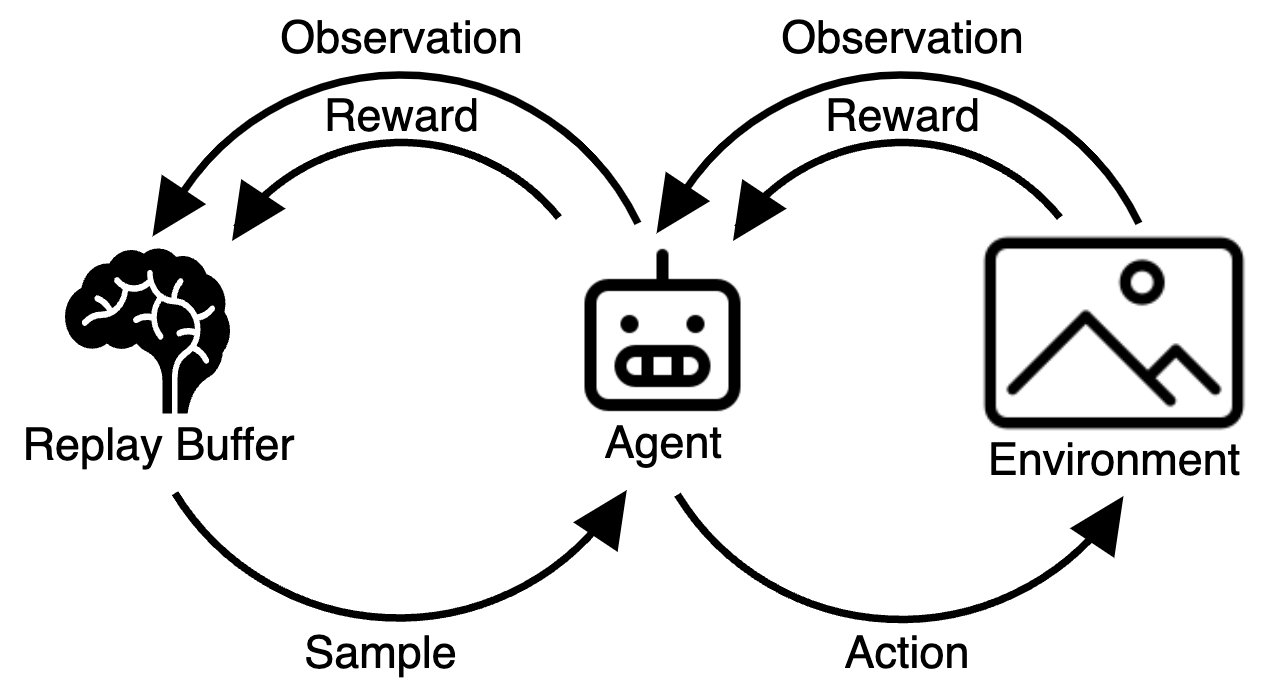

- The Agent interacts with the Environment, taking actions based on its learned policy.
- The Replay Buffer stores past experiences `(state, action, reward, next state, done)`.
- Instead of updating after every step, the agent samples from the buffer and learns from past interactions.

This framework is used in naive DQN, DQN and DDQN to stabilize Q-learning.



## Implement Replay Buffer and Functions

In [ ]:
# Store (state, action, reward, next_state, done)
def store_experience(replay_buffer, state, action, reward, next_stat, done):
        replay_buffer.append((state, action, reward, next_state, done))

# Sample (state, action, reward, next_state, done) mini-batch for training
def sample_experience(replay_buffer, batch_size):

    # Ensure we have enough samples
    assert len(replay_buffer) >= batch_size, (
        f"Not enough samples in buffer to sample {batch_size} items.")

    # Sample a mini-batch
    minibatch = random.sample(replay_buffer, batch_size)

    states, actions, rewards, next_states, dones = zip(*minibatch)

    states = np.array(states, dtype=np.float32).squeeze()
    next_states = np.array(next_states, dtype=np.float32).squeeze()
    actions = np.array(actions, dtype=np.int32)
    rewards = np.array(rewards, dtype=np.float32)
    dones = np.array(dones, dtype=np.float32)

    return states, actions, rewards, next_states, dones

# [Hint] You may find the following statements useful
"""
# Define replay buffer
replay_buffer = deque(maxlen=10000)

# Store experience tuple into replay_buffer
store_experience(replay_buffer, state, action, reward, next_state, done)

# Sample mini-batch of size ba from replay_buffer
states, actions, rewards, next_states, dones = sample_experience(replay_buffer, ba)
"""

'\n# Define replay buffer\nreplay_buffer = deque(maxlen=10000)\n\n# Store experience tuple into replay_buffer\nstore_experience(replay_buffer, state, action, reward, next_state, done)\n\n# Sample mini-batch of size ba from replay_buffer\nstates, actions, rewards, next_states, dones = sample_experience(replay_buffer, ba)\n'

# Naive DQN - Baseline

In this section, you will complete the Naive DQN alorithm by implementing the missing components marked as `[WriteCode]`.



## Define and Compile the Neural Network

A single network $Q_\theta$ (parameterized by $\theta$) is used to approximate $Q(s,a)$.

The target used by Naive DQN is then:

$Y^{NaiveQ}_t = R_{t+1} + \gamma Q_{\theta}(S_{t+1}, a)$

In [ ]:
# Naive DQN Baseline Model
from keras.models import Sequential
from keras.layers import Dense


# [WriteCode] from ... import ...

# Define the Q-network
model = Sequential()

# [WriteCode]
# model.add(...

# Compile the model
# [WriteCode]

# Print the model summary
# [WriteCode]

## Set Up Env and Train the Policy

In [ ]:
# For logging
train_reward_lst = []
eval_reward_mean_lst = []
eval_reward_var_lst = []

# Set up environment
env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0] # Number of observations (CartPole)
action_size = env.action_space.n            # Number of possible actions

model_dir = "naive_dqn_baseline"  # TensorBoard log directory
cb = keras.callbacks.TensorBoard(log_dir = get_run_logdir(model_dir), histogram_freq=1)

# For timing training
total_training_time = 0

# Define replay buffer
# [WriteCode]
# replay_buffer = ...

for ep in range(episode):
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0

    # record start time
    start = time.time()

    for _ in range(500):
        # Interact with the environment with epsilon-greedy policy
        if np.random.rand() <= epsilon:
            action = np.random.choice(action_size)
        else:
            pass # remove pass and use 2 lines below
#            q_values = model.predict(state, verbose=0)
#            action = np.argmax(q_values)

        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        done = terminated or truncated

        # store experience into replay buffer
        # [WriteCode]

        state = next_state
        total_reward += reward

        if done:
            break


#        if len(replay_buffer) >= ba:
            # Update policy with mini-batches if replay buffer contains enough samples
            # Update policy using Q-Learning update:  Q(s, a) = r + gamma * max Q(s', a')
            # [WriteCode]

            # Hints:

            # 1. Compute target Q-values:
            # - If done, Q-target = reward (no future reward)
            # - Otherwise, Q-target = reward + gamma * max(Q(next_state, a))

            # 2. Predict current Q-values for state
            # Update only the Q-value for the taken action

            # 3. Fit the model:
            # - Inputs: state
            # - Targets: updated Q-values (with action Q-value replaced by computed target)

            # Update exploration rate
            if epsilon > epsilon_min:
                epsilon *= epsilon_decay

    # record end time and log training time
    end = time.time()
    total_training_time += end - start

    # Evaluation
    # [WriteCode]


    print(f"Episode {ep + 1}/{episode} | Ep. Total Reward: {total_reward}"
        f" | Epsilon : {epsilon:.3f}")
#        f" | Eval Rwd Mean: {eval_reward_mean:.2f}"
#        f" | Eval Rwd Var: {eval_reward_var:.2f}")

    # Log
#    eval_reward_mean_lst.append(eval_reward_mean)
#    eval_reward_var_lst.append(eval_reward_var)
#    train_reward_lst.append(total_reward)

    # Early Stopping Condition to avoid overfitting
    # If the evaluation reward reaches the specified threshold, stop training early.
    # The default threshold is set to 500, but you should adjust this based on observed training performance.
#    if eval_reward_mean > 500: # [Modify this threshold as needed]
#        print(f"Early stopping triggered at Episode {ep + 1}.")
#        break

# evaluate average training time per episode
print(f"Training time: {total_training_time/episode:.4f} seconds per episode")

env.close()

Episode 1/250 | Ep. Total Reward: 9.0 | Epsilon : 0.000
Episode 2/250 | Ep. Total Reward: 8.0 | Epsilon : 0.000
Episode 3/250 | Ep. Total Reward: 10.0 | Epsilon : 0.000
Episode 4/250 | Ep. Total Reward: 10.0 | Epsilon : 0.000
Episode 5/250 | Ep. Total Reward: 8.0 | Epsilon : 0.000
Episode 6/250 | Ep. Total Reward: 9.0 | Epsilon : 0.000
Episode 7/250 | Ep. Total Reward: 9.0 | Epsilon : 0.000
Episode 8/250 | Ep. Total Reward: 9.0 | Epsilon : 0.000
Episode 9/250 | Ep. Total Reward: 9.0 | Epsilon : 0.000
Episode 10/250 | Ep. Total Reward: 10.0 | Epsilon : 0.000
Episode 11/250 | Ep. Total Reward: 10.0 | Epsilon : 0.000
Episode 12/250 | Ep. Total Reward: 10.0 | Epsilon : 0.000
Episode 13/250 | Ep. Total Reward: 10.0 | Epsilon : 0.000
Episode 14/250 | Ep. Total Reward: 8.0 | Epsilon : 0.000
Episode 15/250 | Ep. Total Reward: 9.0 | Epsilon : 0.000
Episode 16/250 | Ep. Total Reward: 9.0 | Epsilon : 0.000
Episode 17/250 | Ep. Total Reward: 10.0 | Epsilon : 0.000
Episode 18/250 | Ep. Total Reward

## Plot Results

In [ ]:
# Write code to plot
# 1) Moving Averaged Training Reward, 2) Evaluation Mean, 3) Evaluation Variance
# [Write Code]

# plot_smoothed_training_rwd(...

# plot_eval_rwd_mean(...

# plot_eval_rwd_var(...


# Naive DQN - Alternative
You may insert extra cells in the notebook to perform tuning experiments and log results effectively. Use TensorBoard, plots, or tables to visualize the impact of different hyperparameter choices.

In [ ]:
# [Write Code]

## Comparison

Compare performance of the Baseline and the Alternative Naive DQN Policies

In [ ]:
# [Write Code]

# DQN

In this section, you will complete the DQN algorithm by implementing the missing components marked as `[WriteCode]`.


## Define and Compile the Neural Networks

The standard DQN [https://arxiv.org/abs/1312.5602] approach features a periodically updated target network to stabilize training:

- `target_model`: A periodically updated network that stabilizes training. During training, this network is used to compute $Q(S_{t+1}, a)$ for each possible action $a$. This network is not actively trained, but at regular intervals, its weights are copied from `eval_model`. This prevents rapid fluctuations in target Q-values and improves learning stability.

- `eval_model`: The online learning network that interacts with the environment. During training, this network is used to compute $Q(S_{t}, a)$ for each possible action $a$. It updates its weights by minimizing the difference between predicted and target Q-values, improving the agent's decision-making over time.

The target used by DQN is then:

$Y^{Q}_t = R_{t+1} + \gamma \max_a Q_{target}(S_{t+1}, a)$

In the following section, define `[eval_model]` and `[target_model]` with identical architectures.

In [ ]:
# DQN Baseline Model
from keras.models import Sequential
from keras.layers import Dense


# [WriteCode] from ... import ...

# Define the eval (online) network
eval_model = Sequential()

# [WriteCode]
# model.add(...

# Compile the model
# [WriteCode]

# Print the model summary
# [WriteCode]


# Create target_model with the same architecture
target_model = Sequential()

# [WriteCode]
# model.add(...

# Skip compiling as target_model will not be trained with .fit()
# Instead, weights will be copied from the online model
target_model.set_weights(eval_model.get_weights())

# Print the model summary
# [WriteCode]
print(target_model.summary())

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


## Set Up Env and Train the Policy

In this section, you will complete the DQN training routine by implementing the missing components marked as `[WriteCode]`.




In [ ]:
# For logging
train_reward_lst = []
eval_reward_mean_lst = []
eval_reward_var_lst = []

# Set up environment
env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0] # Number of observations (CartPole)
action_size = env.action_space.n            # Number of possible actions

model_dir = "dqn_baseline"   # TensorBoard log directory
cb = keras.callbacks.TensorBoard(log_dir = get_run_logdir(model_dir), histogram_freq=1)

# Train Counter for weight syncing
train_counter = 0

# For timing training
total_training_time = 0

# Define replay buffer
# replay_buffer = ...

for ep in range(episode):
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0

    # record start time
    start = time.time()

    for _ in range(500):
        # Interact with the environment with epsilon-greedy policy
        if np.random.rand() <= epsilon:
            action = np.random.choice(action_size)
        else:
            pass # remove pass and 2 lines below
#            q_values = eval_model.predict(state, verbose=0)
#            action = np.argmax(q_values)

        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        done = terminated or truncated

        # store experience into replay buffer
        # [WriteCode]

        state = next_state
        total_reward += reward

        if done:
            break

        # if len(replay_buffer) >= ba:
            # train_counter += 1
            # Update policy with mini-batches if replay buffer contains enough samples
            # Update policy using Deep Q-Learning update: Q(s, a) = r + gamma * max Q_target(S', a)
            # [WriteCode]

            # Compute target Q-values:
            # - If done, Q-target = reward (no future reward)
            # - Otherwise, Q-target = reward + gamma * max(Q_target(next_state, a))

            # Predict current Q-values for state using eval_model
            # Predict future Q-values using target_model (NOT eval_model)

            # Update only the Q-value for the taken action

            # Fit the model:
            # - Inputs: state
            # - Targets: updated Q-values (with action Q-value replaced by computed target)


            # Update exploration rate
            if epsilon > epsilon_min:
                epsilon *= epsilon_decay

            # Periodically update the target network
            if train_counter % target_update_freq == 0:
                target_model.set_weights(eval_model.get_weights())

    # record end time and log training time
    end = time.time()
    total_training_time += end - start

    # Evaluation
    # [WriteCode]

    print(f"Episode {ep + 1}/{episode} | Ep. Total Reward: {total_reward}"
        f" | Epsilon : {epsilon:.3f}")
#        f" | Eval Rwd Mean: {eval_reward_mean:.2f}"
#        f" | Eval Rwd Var: {eval_reward_var:.2f}")

    # Log
#    eval_reward_mean_lst.append(eval_reward_mean)
#    eval_reward_var_lst.append(eval_reward_var)
#    train_reward_lst.append(total_reward)

    # Early Stopping Condition to avoid overfitting
    # If the evaluation reward reaches the specified threshold, stop training early.
    # The default threshold is set to 500, but you should adjust this based on observed training performance.
#    if eval_reward_mean > 500: # [Modify this threshold as needed]
#        print(f"Early stopping triggered at Episode {ep + 1}.")
#        break

# evaluate average training time per episode
print(f"Training time: {total_training_time/episode:.4f} seconds per episode")

env.close()

Episode 1/250 | Ep. Total Reward: 8.0 | Epsilon : 0.000
Episode 2/250 | Ep. Total Reward: 9.0 | Epsilon : 0.000
Episode 3/250 | Ep. Total Reward: 10.0 | Epsilon : 0.000
Episode 4/250 | Ep. Total Reward: 9.0 | Epsilon : 0.000
Episode 5/250 | Ep. Total Reward: 9.0 | Epsilon : 0.000
Episode 6/250 | Ep. Total Reward: 10.0 | Epsilon : 0.000
Episode 7/250 | Ep. Total Reward: 8.0 | Epsilon : 0.000
Episode 8/250 | Ep. Total Reward: 9.0 | Epsilon : 0.000
Episode 9/250 | Ep. Total Reward: 9.0 | Epsilon : 0.000
Episode 10/250 | Ep. Total Reward: 10.0 | Epsilon : 0.000
Episode 11/250 | Ep. Total Reward: 9.0 | Epsilon : 0.000
Episode 12/250 | Ep. Total Reward: 10.0 | Epsilon : 0.000
Episode 13/250 | Ep. Total Reward: 9.0 | Epsilon : 0.000
Episode 14/250 | Ep. Total Reward: 8.0 | Epsilon : 0.000
Episode 15/250 | Ep. Total Reward: 10.0 | Epsilon : 0.000
Episode 16/250 | Ep. Total Reward: 9.0 | Epsilon : 0.000
Episode 17/250 | Ep. Total Reward: 11.0 | Epsilon : 0.000
Episode 18/250 | Ep. Total Reward:

## Plot Results

In [ ]:
# Write code to plot
# 1) Moving Averaged Training Reward, 2) Evaluation Mean, 3) Evaluation Variance
# [Write Code]
plot_smoothed_training_rwd(train_reward_lst, window_size=20)
plot_eval_rwd_mean(eval_reward_mean_lst)
plot_eval_rwd_var(eval_reward_var_lst)

ValueError: v cannot be empty

# DQN - Alternative

You may insert extra cells in the notebook to perform tuning experiments and log results effectively. Use TensorBoard, plots, or tables to visualize the impact of different hyperparameter choices.

## Plot Results

In [ ]:
# Write code to plot
# 1) Moving Averaged Training Reward, 2) Evaluation Mean, 3) Evaluation Variance
# [Write Code]

# plot_smoothed_training_rwd(...

# plot_eval_rwd_mean(...

# plot_eval_rwd_var(...

In [ ]:
# [Write Code]

## Comparison

Compare performance of the Baseline and the Alternative DQN Policies

In [ ]:
# [Write Code]

# DDQN

## Define and Compile the Neural Networks

The Double Deep Q-Network (DDQN) [https://arxiv.org/abs/1509.06461] improves upon standard DQN by reducing overestimation bias in Q-values. DDQN achieves this by decoupling action selection from value estimation using two networks, which is almost identical as DQN:

- `target_model`: A periodically updated network that stabilizes training. During training, this network is used to compute $Q(S_{t+1}, a)$ for each possible action $a$. This network is also not trained but synced from `eval_model`. **However, unlike DQN, this network is only used to evaluate the Q-value of the action chosen by `eval_model`, making value updates more stable.**

- `eval_model`: The online learning network that interacts with the environment. During training, this network is used to select the best action using $\arg\max_a Q(S_{t}, a)$ and updates its weights by minimizing the difference between predicted and target Q-value.

The target used by DDQN is then:

$Y^{Q}_t = R_{t+1} + \gamma Q_{target}(S_{t+1}, \arg \max_{a} Q_{eval}(S_{t+1}, a))$

In [ ]:
# DDQN Baseline Model
from keras.models import Sequential
from keras.layers import Dense


# [WriteCode] from ... import ...

# Define the eval (online) network
eval_model = Sequential()

# [WriteCode]
# model.add(...

# Compile the model
# [WriteCode]

# Print the model summary
# [WriteCode]



# Create target_model with the same architecture
target_model = Sequential()

# [WriteCode]
# model.add(...

# Skip compiling as target_model will not be trained with .fit()
# Instead, weights will be copied from the online model
# target_model.set_weights(eval_model.get_weights())

# Print the model summary
# [WriteCode]

## Set Up Env and Train the Policy

In [ ]:
# For logging
train_reward_lst = []
eval_reward_mean_lst = []
eval_reward_var_lst = []

# Set up environment
env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0] # Number of observations (CartPole)
action_size = env.action_space.n            # Number of possible actions

model_dir = "ddqn_baseline"  # TensorBoard log directory
cb = keras.callbacks.TensorBoard(log_dir = get_run_logdir(model_dir), histogram_freq=1)

# Train Counter for weight syncing
train_counter = 0

# For timing training
total_training_time = 0

# Define replay buffer
# replay_buffer = ...

for ep in range(episode):
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0

    # record start time
    start = time.time()

    for _ in range(500):

        # Interact with the environment with epsilon-greedy policy
        if np.random.rand() <= epsilon:
            action = np.random.choice(action_size)
        else:
            pass # remove pass and use 2 lines below
#            q_values = eval_model.predict(state, verbose=0)
#            action = np.argmax(q_values)

        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        done = terminated or truncated

        # store experience into replay buffer
        # [WriteCode]

        state = next_state
        total_reward += reward

        if done:
            break

#        if len(replay_buffer) >= ba:
#            train_counter += 1
            # Update policy with mini-batches if replay buffer contains enough samples
            # Update policy using Double Deep Q-Learning update:
            # Q(s, a) = r + gamma * Q_target(S', argmax Q_eval(S', a))
            # [WriteCode]

            # Compute target Q-values:
            # - If done, Q-target = reward (no future reward)
            # - Otherwise, Q-target = reward + gamma * Q_target(S', argmax Q_eval(S', a))

            # Predict current Q-values for state using eval_model
            # Use eval_model to determine best action in next_state
            # Use target_model to compute Q-value for that action

            # Update only the Q-value for the taken action

            # Fit the model:
            # - Inputs: state
            # - Targets: updated Q-values (with action Q-value replaced by computed target)


            # Update exploration rate
            if epsilon > epsilon_min:
                epsilon *= epsilon_decay

            # Periodically update the target network
 #           if train_counter % target_update_freq == 0:
 #               target_model.set_weights(eval_model.get_weights())

    # record end time and log training time
    end = time.time()
    total_training_time += end - start

    # Evaluation
    # [WriteCode]

    print(f"Episode {ep + 1}/{episode} | Ep. Total Reward: {total_reward}"
        f" | Epsilon : {epsilon:.3f}")
#        f" | Eval Rwd Mean: {eval_reward_mean:.2f}"
#        f" | Eval Rwd Var: {eval_reward_var:.2f}")

    # Log
#    eval_reward_mean_lst.append(eval_reward_mean)
#    eval_reward_var_lst.append(eval_reward_var)
    train_reward_lst.append(total_reward)

    # Early Stopping Condition to avoid overfitting
    # If the evaluation reward reaches the specified threshold, stop training early.
    # The default threshold is set to 500, but you should adjust this based on observed training performance.
#    if eval_reward_mean > 500: # [Modify this threshold as needed]
#        print(f"Early stopping triggered at Episode {ep + 1}.")
#        break

# record end time and calculate average training time per episode
# evaluate average training time per episode
print(f"Training time: {total_training_time/episode:.4f} seconds per episode")

env.close()

Episode 1/250 | Ep. Total Reward: 9.0 | Epsilon : 0.000
Episode 2/250 | Ep. Total Reward: 8.0 | Epsilon : 0.000
Episode 3/250 | Ep. Total Reward: 10.0 | Epsilon : 0.000
Episode 4/250 | Ep. Total Reward: 9.0 | Epsilon : 0.000
Episode 5/250 | Ep. Total Reward: 8.0 | Epsilon : 0.000
Episode 6/250 | Ep. Total Reward: 10.0 | Epsilon : 0.000
Episode 7/250 | Ep. Total Reward: 8.0 | Epsilon : 0.000
Episode 8/250 | Ep. Total Reward: 10.0 | Epsilon : 0.000
Episode 9/250 | Ep. Total Reward: 9.0 | Epsilon : 0.000
Episode 10/250 | Ep. Total Reward: 9.0 | Epsilon : 0.000
Episode 11/250 | Ep. Total Reward: 9.0 | Epsilon : 0.000
Episode 12/250 | Ep. Total Reward: 8.0 | Epsilon : 0.000
Episode 13/250 | Ep. Total Reward: 10.0 | Epsilon : 0.000
Episode 14/250 | Ep. Total Reward: 10.0 | Epsilon : 0.000
Episode 15/250 | Ep. Total Reward: 9.0 | Epsilon : 0.000
Episode 16/250 | Ep. Total Reward: 8.0 | Epsilon : 0.000
Episode 17/250 | Ep. Total Reward: 10.0 | Epsilon : 0.000
Episode 18/250 | Ep. Total Reward:

## Plot Results

In [ ]:
# Write code to plot
# 1) Moving Averaged Training Reward, 2) Evaluation Mean, 3) Evaluation Variance
# [Write Code]

# plot_smoothed_training_rwd(...

# plot_eval_rwd_mean(...

# plot_eval_rwd_var(...

# DDQN - Alternative

You may insert extra cells in the notebook to perform tuning experiments and log results effectively. Use TensorBoard, plots, or tables to visualize the impact of different hyperparameter choices.

In [ ]:
# [Write Code]

## Comparison

Compare performance of the Baseline and the Alternative DDQN Policies

In [ ]:
# [Write Code]

# Visualize with Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./eec4400_logs --port=6006

# Comparison Across Four Alternative Policies

Compare hyperparameters and performance of the four alternative policies.

You may insert extra cells in the notebook to tabulate/plot/log results effectively.

In [ ]:
# [Write Code]